In [8]:
%matplotlib inline
import pathlib
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 8, 6
import pandas as pd
import numpy as np
import seaborn as sns
pd.set_option('display.max_columns', 500)
from collections import defaultdict

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity='all'

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error

pd.options.mode.chained_assignment = None

from torch.nn import init
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils import data
from torch.optim import lr_scheduler

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device
import glob
from tqdm import tqdm, tqdm_notebook, tnrange
tqdm.pandas(desc='Progress')
from sklearn import preprocessing

device(type='cuda', index=0)

C:\Users\kevin\Anaconda3\envs\tensorflow_env\lib\site-packages\tqdm\std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [3]:
from market import *
from market_ml import *

In [4]:
class RegressionColumnarDataset(torch.utils.data.Dataset):
    def __init__(self, df, cats, y):
        self.dfcats = df[cats]
        self.dfconts = df.drop(cats, axis=1)
        
        self.cats = np.stack([c.values for n, c in self.dfcats.items()], axis=1).astype(np.int64)
        self.conts = np.stack([c.values for n, c in self.dfconts.items()], axis=1).astype(np.float32)
        self.y = y.values.astype(np.float32)
        
    def __len__(self): return len(self.y)
 
    def __getitem__(self, idx):
        return [self.cats[idx], self.conts[idx], self.y[idx]]
    
def apply_dl(X, y, categorical):
    ds = RegressionColumnarDataset(X, categorical, y)
    params = {'batch_size': 128,
          'shuffle': True,
          'num_workers': 0}
    return torch.utils.data.DataLoader(ds, **params)

In [5]:
def load_csv_data():
    csv_filenames = glob.glob("csv_files/company_stats_*.csv")
    financial_data = pd.DataFrame()
    for csv_name in tqdm(csv_filenames):
        # Remove rows with nan values for industry and sector
        try:
            daily_data = pd.read_csv(csv_name, encoding='cp1252')
            daily_data = daily_data[pd.notnull(daily_data['Industry'])] 
            daily_data = daily_data[pd.notnull(daily_data['Sector'])]
            financial_data = financial_data.append(daily_data, sort=False)
        except:
            print('Importing data from', csv_name, 'failed.')

    financial_data = financial_data.reset_index()
    print('Master dataframe columns: ', financial_data.columns)

    # Convert sector and industry to categoricals
    financial_data['Industry'] = financial_data['Industry'].astype('category')
    financial_data['Sector'] = financial_data['Sector'].astype('category')

    to_remove = ['Ticker', 'Name', 'Price', 'IPO Year']
    categorical = ['Sector', 'Industry']

    # Convert categorical variables to integers to feed in the model
    financial_data[categorical] = financial_data[categorical].apply(lambda x: x.cat.codes)
    feature_cols = [x for x in financial_data.columns if x not in to_remove]
    financial_data = financial_data.fillna(0)
    X = financial_data[feature_cols]
    Y = financial_data['Price']
    
    return X, Y


X, Y = load_csv_data()
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=123)
    
# Covert to dataloaders
traindl = apply_dl(X_train, y_train, categorical)
valdl = apply_dl(X_test, y_test, categorical)

 75%|███████▍  | 164/219 [01:05<00:51,  1.08it/s]

Importing data from csv_files\company_stats_2020-04-09.csv failed.


 86%|████████▌ | 188/219 [01:27<00:30,  1.00it/s]

Importing data from csv_files\company_stats_2020-05-17.csv failed.


100%|██████████| 219/219 [01:59<00:00,  1.83it/s]


Master dataframe columns:  Index(['index', 'Ticker', 'Name', 'Sector', 'Industry', 'IPO Year', 'Price',
       'Market Cap', 'Trailing P/E', 'Forward P/E', 'PEG Ratio(5yr Expected)',
       'Price/Sales(ttm)', 'Price/Book', 'Enterprise Value/Revenue',
       'Enterprise Value/EBITDA', 'Profit Margin', 'Operating Margin(TTM)',
       'Return on Assets(TTM)', 'Return on Equity(TTM)', 'Revenue(TTM)',
       'Revenue Per Share(TTM)', 'Quarterly Revenue Growth(YOY)',
       'Gross Profit(TTM)', 'EBITDA', 'Diluted EPS(TTM)',
       'Quarterly Earnings Growth(YOY)', 'Total Cash', 'Total Cash Per Share',
       'Total Debt', 'Total Debt/Equity', 'Current Ratio',
       'Book Value Per Share', 'Operating Cash Flow(TTM)',
       'Levered Free Cash Flow(TTM)', 'Beta(3Y Monthly)', 'Shares Outstanding',
       'Forward Annual Dividend Rate', 'Forward Annual Dividend Yield',
       'Trailing Annual Dividend Rate', 'Trailing Annual Dividend Yield',
       '5 Year Average Dividend Yield', 'Payout Rati

In [6]:
def parse_col_attributes(col_name):
    replacements = {
                        '(TTM)' : '',
                        '(ttm)' : '',
                        '(YOY)' : '',
                        ' (intraday)' : '',
                        ' (5 yr expected)' : '',
                        '(5yr Expected)': '',
                        '(3Y Monthly)' : '',
                        ' (3Y Monthly)' : '',
                        ' Avi to Common' : '',
                        'Trailing Annual ' : ''
                   }
    for code, replacement in replacements.items():
        col_name = col_name.replace(code, replacement)
    return col_name


# Get the unique column values in the dataframe so we can combine data
unique_attributes = set([parse_col_attributes(col) for col in financial_data.columns])
    
# Iterate through attributes and fill master_data
master_data = pd.DataFrame()
for attribute in tqdm(unique_attributes):
    supporting_attributes = [x for x in financial_data.columns if attribute in x]
    master_data[attribute] = financial_data[supporting_attributes[0]]
    # Combine columns with same attribute using the non zero value
    for i in range(1, len(supporting_attributes)):
        master_data[attribute] = master_data[attribute].combine(financial_data[supporting_attributes[i]], lambda x, y: x if (y == 0 or float('nan')) else y)
    
master_data.head()

100%|██████████| 46/46 [10:45<00:00, 14.03s/it]


,Ticker,Sector,Diluted EPS,Revenue Per Share,Trailing P/E,Forward Annual Dividend Rate,Price/Book,Industry,Revenue,Enterprise Value/EBITDA,Return on Equity,EBITDA,Operating Cash Flow,Gross Profit,Quarterly Earnings Growth,PEG Ratio,Total Cash,Total Debt/Equity,Name,Total Debt,Enterprise Value,Return on Assets,Price,EPS Beat Ratio,Current Ratio,Enterprise Value/Revenue,Operating Margin,IPO Year,Market Cap,Total Cash Per Share,Profit Margin,Price/Sales,Levered Free Cash Flow,Forward Annual Dividend Yield,5 Year Average Dividend Yield,Beta,Net Income,Payout Ratio,Beta,Dividend Yield,Shares Outstanding,Dividend Rate,index,Book Value Per Share,Quarterly Revenue Growth,Forward P/E
0,PIH,12,-1.185,9.73,0,0.00,0.69,327,0.76,118.12,0.97,118.12,8630000.0,15490000.0,0.0,0.00,2310000.0,0.0,"1347 Property Insurance Holdings, Inc.",0.0,0.76,0.10,4.8348,0.0,1.35,0.76,0.42,2014.0,2.922200e+07,0.38,-9.79,0.50,-80710000.0,0.00,0.00,0.0,0.0,0.00,0.37,0.00,6010000.0,0.00,0,7.00,0.0,0.00
1,TURN,12,-0.091,0.01,0,0.00,0.75,156,282.44,-24.40,-3.19,-24.40,-5850000.0,0.0,-39.9,0.00,5870000.0,0.0,180 Degree Capital Corp.,0.0,282.44,-1.64,2.1294,0.0,1.45,282.44,0.00,0.0,6.654100e+07,0.19,0.00,314.30,2120000.0,0.00,0.00,0.0,0.0,0.00,0.69,0.00,31120000.0,0.00,1,2.82,0.0,0.00
2,FLWS,10,0.520,19.41,28.31,0.00,2.76,303,0.72,11.96,10.57,11.96,78100000.0,526120000.0,0.0,1.34,172920000.0,28.3,"1-800 FLOWERS.COM, Inc.",96970000.0,0.72,4.79,15.4100,0.0,2.38,0.72,3.61,1999.0,9.542680e+08,2.69,2.78,0.76,34370000.0,0.00,0.00,0.0,0.0,0.00,1.24,0.00,35770000.0,0.00,2,5.33,0.0,21.65
3,FCCY,12,1.620,6.13,10.77,0.30,1.11,379,4.95,0.00,11.03,0.00,14330000.0,50220000.0,80.1,1.32,30110000.0,0.0,1st Constitution Bancorp (NJ),139430000.0,4.95,1.11,17.1200,0.0,0.00,4.95,38.79,0.0,1.483110e+08,3.48,26.98,2.84,0.0,1.77,0.00,0.0,0.0,17.59,0.13,1.77,8630000.0,0.30,3,15.62,0.0,9.78
4,SRCE,12,3.350,11.61,13.25,1.08,1.43,240,4.52,0.00,11.25,0.00,130670000.0,291490000.0,6.5,1.23,117890000.0,0.0,1st Source Corporation,348340000.0,4.52,1.34,44.0200,0.0,0.00,4.52,39.49,0.0,1.133000e+09,4.62,29.01,3.78,0.0,2.48,1.95,0.0,0.0,31.04,1.36,2.48,25960000.0,1.08,4,31.12,0.0,12.09


In [7]:
master_data_truncated = master_data

In [16]:
# Columns to ignore when training
ignore_columns = ['Price', 'Ticker', 'Name', 'IPO Year', 'Payout Ratio', 'Enterprise Value/EBITDA', 'Enterprise Value/Revenue',
                 'Trailing Annual Dividend Rate', 'Forward Annual Dividend Rate', 'Forward Annual Dividend Yield',
                 '5 Year Average Dividend Yield', 'EPS Beat Ratio', 'Beta ', 'index']
# Keep track of categoricals so we can convert them to numeric
categoricals = ['Sector', 'Industry']

# Store the data we want to learn from in X
X = master_data_truncated[[c for c in master_data_truncated.columns if c not in ignore_columns]]
for c in X.columns:
    X[c] = pd.to_numeric(X[c], errors='coerce')
#X = pd.get_dummies(X, columns=categoricals)
#Y = Y.head(int(len(master_data) / 10))

# Get training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=123)
print('Columns of training data:', X_train.columns)

X_train=(X_train-X_train.min())/(X_train.max()-X_train.min())
y_train=(y_train-y_train.min())/(y_train.max()-y_train.min())
# Standardize the data to mean 0 and std 1 
X_train.loc[:,:] = preprocessing.scale(X_train)
y_train.loc[:,:] = preprocessing.scale(y_train)

# Hyperparameter tune settings for XGBoost model
param_test = {
    'max_depth':[3],
    'min_child_weight':[4],
    'learning_rate':[.25],
    'gamma':[0],
    'reg_alpha':[ 0.1]#, .12, .14]
}

# Define XGB model object
xgbr = xgb.XGBRegressor(objective='reg:squarederror')

# Define grid search object and feed in the model we created
gsearch = GridSearchCV(estimator=xgbr, param_grid=param_test,n_jobs=4,iid=False, cv=5)

# Fit perform the grid search
gsearch.fit(X_train, y_train)
print("Test Score: " + str(gsearch.best_estimator_.score(X_test, y_test)))
model = gsearch.best_estimator_
preds = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))
model.save_model('xgb_main.model')

Columns of training data: Index(['Sector', 'Diluted EPS', 'Revenue Per Share', 'Trailing P/E',
       'Price/Book', 'Industry', 'Revenue', 'Return on Equity', 'EBITDA',
       'Operating Cash Flow', 'Gross Profit', 'Quarterly Earnings Growth',
       'PEG Ratio', 'Total Cash', 'Total Debt/Equity', 'Total Debt',
       'Enterprise Value', 'Return on Assets', 'Current Ratio',
       'Operating Margin', 'Market Cap', 'Total Cash Per Share',
       'Profit Margin', 'Price/Sales', 'Levered Free Cash Flow', 'Net Income',
       'Beta', 'Dividend Yield', 'Shares Outstanding', 'Dividend Rate',
       'Book Value Per Share', 'Quarterly Revenue Growth', 'Forward P/E'],
      dtype='object')


C:\Users\kevin\Anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\preprocessing\data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


IndexingError: (slice(None, None, None), slice(None, None, None))

In [19]:
X_test.columns

Index(['Gross Profit', 'Total Debt', 'Book Value Per Share', 'index',
       'Dividend Yield', 'Shares Outstanding', 'Price/Book', 'PEG Ratio',
       'Forward P/E', 'Quarterly Earnings Growth', 'Revenue Per Share',
       'Total Debt/Equity', 'Beta ', 'Current Ratio', 'Market Cap',
       'Return on Equity', 'Levered Free Cash Flow',
       'Quarterly Revenue Growth', 'Operating Margin', 'Net Income',
       'Industry', 'Return on Assets', 'Dividend Rate', 'Price/Sales',
       'EBITDA', 'Trailing P/E', 'Revenue', 'Beta', 'Diluted EPS',
       'Total Cash Per Share', 'Sector', 'Enterprise Value', 'Profit Margin',
       'Total Cash', 'Operating Cash Flow'],
      dtype='object')

In [3]:
from company import *
company = Company("SNE")
model = xgb.XGBRegressor(objective='reg:squarederror')
model.load_model('xgb_main.model')
company.predict_price_using_xgb(model)

index is not in self.metadata
Beta  is not in self.metadata
Dividend Rate is not in self.metadata
    Gross Profit  Total Debt  Book Value Per Share  Dividend Yield  \
0  2336461000000         NaN          1.973676e-08             0.6   

   Shares Outstanding  Price/Book  PEG Ratio  Forward P/E  \
0          1220160000    3.174985      -1.32    16.585682   

   Quarterly Earnings Growth  Revenue Per Share  ...  Trailing P/E  Revenue  \
0                      -85.6                NaN  ...     16.073154      NaN   

       Beta  Diluted EPS  Total Cash Per Share  Sector  Enterprise Value  \
0  1.151744        4.757                   NaN     NaN       93293428736   

   Profit Margin  Total Cash  Operating Cash Flow  
0          7.048         NaN                  NaN  

[1 rows x 32 columns]


array([209.86879], dtype=float32)

In [9]:
def emb_init(x):
    x = x.weight.data
    sc = 2/(x.size(1)+1)
    x.uniform_(-sc,sc)
    
def inv_y(y): 
    return np.exp(y)
    
def rmse(targ, y_pred):
    #print(inv_y(y_pred), inv_y(targ))
    #return np.sqrt(mean_squared_error(inv_y(y_pred), inv_y(targ))) #.detach().numpy()
    return np.sqrt(mean_squared_error(y_pred, targ))


class MixedInputModel(nn.Module):
    def __init__(self, emb_szs, n_cont, emb_drop, out_sz, szs, drops, y_range, use_bn=True):
        super().__init__()
        for i,(c,s) in enumerate(emb_szs): assert c > 1, "cardinality must be >=2, got emb_szs[{i}]: ({c},{s})"
        self.embs = nn.ModuleList([nn.Embedding(c, s) for c,s in emb_szs])
        for emb in self.embs: emb_init(emb)
        n_emb = sum(e.embedding_dim for e in self.embs)
        self.n_emb, self.n_cont=n_emb, n_cont
        
        szs = [n_emb+n_cont] + szs
        self.lins = nn.ModuleList([nn.Linear(szs[i], szs[i+1]) for i in range(len(szs)-1)])
        self.bns = nn.ModuleList([nn.BatchNorm1d(sz) for sz in szs[1:]])
        for o in self.lins: nn.init.kaiming_normal_(o.weight.data)
        self.outp = nn.Linear(szs[-1], out_sz)
        nn.init.kaiming_normal_(self.outp.weight.data)

        self.emb_drop = nn.Dropout(emb_drop)
        self.drops = nn.ModuleList([nn.Dropout(drop) for drop in drops])
        self.bn = nn.BatchNorm1d(n_cont)
        self.use_bn,self.y_range = use_bn,y_range

    def forward(self, x_cat, x_cont):
        if self.n_emb != 0:
            x = [e(x_cat[:,i]) for i,e in enumerate(self.embs)]
            x = torch.cat(x, 1)
            x = self.emb_drop(x)
        if self.n_cont != 0:
            x2 = self.bn(x_cont)
            x = torch.cat([x, x2], 1) if self.n_emb != 0 else x2
        for l,d,b in zip(self.lins, self.drops, self.bns):
            x = F.relu(l(x))
            if self.use_bn: x = b(x)
            x = d(x)
        x = self.outp(x)
        if self.y_range:
            x = torch.sigmoid(x)
            x = x*(self.y_range[1] - self.y_range[0])
            x = x+self.y_range[0]
        return x.squeeze()

In [16]:
y_range = (0, y_train.max()*1.2)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using: " + str(device))
from tqdm import tqdm, tqdm_notebook, tnrange
tqdm.pandas(desc='Progress')

cat_sz = [(c, financial_data[c].max()+1) for c in categorical]


emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]


net = MixedInputModel(emb_szs=emb_szs,
    n_cont=len(financial_data.columns)-len(categorical) - 4, 
                    emb_drop=0.04,
                    out_sz=1, 
                    szs=[1000,500,250], 
                    drops=[0.001,0.01,0.01], 
                    y_range=y_range).to(device)

Using: cuda:0


C:\Users\kevin\Anaconda3\envs\tensorflow_env\lib\site-packages\tqdm\std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [17]:
def fit(model, train_dl, val_dl, loss_fn, opt, scheduler, epochs=3):
    num_batch = len(train_dl)
    for epoch in tnrange(epochs):      
        y_true_train = list()
        y_pred_train = list()
        total_loss_train = 0          
        t = tqdm(iter(train_dl), leave=False, total=num_batch)
        for cat, cont, y in t:
            cat = cat.cuda()
            cont = cont.cuda()
            y = y.cuda()
            
            t.set_description('Epoch {epoch}')
            
            opt.zero_grad()
            pred = model(cat, cont)
            loss = loss_fn(pred, y)
            loss.backward()
            lr[epoch].append(opt.param_groups[0]['lr'])
            tloss[epoch].append(loss.item())
            opt.step()
            scheduler.step()
            
            t.set_postfix(loss=loss.item())
            
            y_true_train += list(y.cpu().data.numpy())
            y_pred_train += list(pred.cpu().data.numpy())
            total_loss_train += loss.item()
        train_acc = rmse(y_true_train, y_pred_train)
        train_loss = total_loss_train/len(train_dl)
        
        if val_dl:
            y_true_val = list()
            y_pred_val = list()
            total_loss_val = 0
            for cat, cont, y in tqdm(val_dl, leave=False):
                cat = cat.cuda()
                cont = cont.cuda()
                y = y.cuda()
                pred = model(cat, cont)
                loss = loss_fn(pred, y)
                
                y_true_val += list(y.cpu().data.numpy())
                y_pred_val += list(pred.cpu().data.numpy())
                total_loss_val += loss.item()
                vloss[epoch].append(loss.item())
            valacc = rmse(y_true_val, y_pred_val)
            valloss = total_loss_val/len(valdl)
            print(f'Epoch {epoch}: train_loss: {train_loss:.4f} train_rmse: {train_acc:.4f} | val_loss: {valloss:.4f} val_rmse: {valacc:.4f}')
        else:
            print(f'Epoch {epoch}: train_loss: {train_loss:.4f} train_rmse: {train_acc:.4f}')
    
    return lr, tloss, vloss

In [18]:
opt = optim.Adam(net.parameters(), 1e-2)
lr_cosine = lr_scheduler.CosineAnnealingLR(opt, 1000)
 
lr = defaultdict(list)
tloss = defaultdict(list)
vloss = defaultdict(list)
 
lr, tloss, vloss = fit(model=net, train_dl=traindl, val_dl=valdl, loss_fn=F.mse_loss, opt=opt, scheduler=lr_cosine, epochs=50)

Epoch 0: train_loss: 143187.8867 train_rmse: 380.3524 | val_loss: 61331.3984 val_rmse: 247.9860


Epoch 1: train_loss: 42662.5648 train_rmse: 206.4694 | val_loss: 23839.9443 val_rmse: 154.2657


Epoch 2: train_loss: 23486.3899 train_rmse: 149.1934 | val_loss: 19826.0840 val_rmse: 140.9616


Epoch 3: train_loss: 14543.7830 train_rmse: 120.0164 | val_loss: 11771.1118 val_rmse: 108.3218


Epoch 4: train_loss: 14461.9428 train_rmse: 116.8064 | val_loss: 15204.5037 val_rmse: 123.2112


Epoch 5: train_loss: 12083.2050 train_rmse: 109.4976 | val_loss: 9274.1831 val_rmse: 96.3269


Epoch 6: train_loss: 9508.1729 train_rmse: 97.7069 | val_loss: 7797.2927 val_rmse: 88.3143


Epoch 7: train_loss: 7159.7936 train_rmse: 85.4145 | val_loss: 4835.0792 val_rmse: 69.6528


Epoch 8: train_loss: 2676.9693 train_rmse: 52.2332 | val_loss: 2998.1369 val_rmse: 54.8395


Epoch 9: train_loss: 1735.1614 train_rmse: 41.5855 | val_loss: 2740.0311 val_rmse: 52.4122


Epoch 10: train_loss: 1583.4377 train_rmse: 39.3441 | val_loss: 1819.1826 val_rmse: 42.5806


Epoch 11: train_loss: 1415.2400 train_rmse: 37.3986 | val_loss: 2401.2045 val_rmse: 48.9974


Epoch 12: train_loss: 2487.3224 train_rmse: 48.3532 | val_loss: 3380.5993 val_rmse: 58.3112


Epoch 13: train_loss: 1985.2265 train_rmse: 44.9665 | val_loss: 2437.4544 val_rmse: 49.4118


Epoch 14: train_loss: 2075.7595 train_rmse: 45.7832 | val_loss: 2451.0959 val_rmse: 49.5564


Epoch 15: train_loss: 1646.2713 train_rmse: 40.7855 | val_loss: 1711.1389 val_rmse: 41.3387


Epoch 16: train_loss: 1342.1066 train_rmse: 36.3244 | val_loss: 2706.0354 val_rmse: 51.7468


Epoch 17: train_loss: 1232.7868 train_rmse: 34.8426 | val_loss: 2697.6000 val_rmse: 52.0755


Epoch 18: train_loss: 1523.0074 train_rmse: 38.8335 | val_loss: 2263.8178 val_rmse: 47.4521


Epoch 19: train_loss: 1195.1422 train_rmse: 34.6402 | val_loss: 1810.0902 val_rmse: 42.5341


Epoch 20: train_loss: 1056.3391 train_rmse: 32.4586 | val_loss: 1874.5223 val_rmse: 43.2818


Epoch 21: train_loss: 922.3789 train_rmse: 30.5236 | val_loss: 1887.0161 val_rmse: 43.4477


Epoch 22: train_loss: 954.3424 train_rmse: 30.7996 | val_loss: 1723.1543 val_rmse: 41.3798


Epoch 23: train_loss: 950.9985 train_rmse: 30.2787 | val_loss: 1593.2052 val_rmse: 39.8929


Epoch 24: train_loss: 974.9548 train_rmse: 31.5040 | val_loss: 1877.6741 val_rmse: 43.3968


Epoch 25: train_loss: 1002.8527 train_rmse: 30.8385 | val_loss: 1522.5733 val_rmse: 38.9560


Epoch 26: train_loss: 822.8628 train_rmse: 28.9190 | val_loss: 1768.8363 val_rmse: 42.1615


Epoch 27: train_loss: 930.4333 train_rmse: 29.7077 | val_loss: 1553.0998 val_rmse: 39.3339


Epoch 28: train_loss: 774.7160 train_rmse: 27.9390 | val_loss: 1274.6051 val_rmse: 35.7860


Epoch 29: train_loss: 779.9548 train_rmse: 28.0416 | val_loss: 1566.4821 val_rmse: 39.6351


Epoch 30: train_loss: 834.5501 train_rmse: 28.2992 | val_loss: 1703.0353 val_rmse: 41.2271


Epoch 31: train_loss: 717.7432 train_rmse: 27.0968 | val_loss: 1937.1578 val_rmse: 44.0460


Epoch 32: train_loss: 856.3053 train_rmse: 28.8783 | val_loss: 1429.7929 val_rmse: 37.8479


Epoch 33: train_loss: 744.3978 train_rmse: 26.9310 | val_loss: 1624.4129 val_rmse: 40.3265


Epoch 34: train_loss: 739.6438 train_rmse: 27.0740 | val_loss: 1518.7814 val_rmse: 39.0461


Epoch 35: train_loss: 977.4771 train_rmse: 29.8315 | val_loss: 1635.8975 val_rmse: 40.3657


Epoch 36: train_loss: 819.2220 train_rmse: 28.8090 | val_loss: 1501.9390 val_rmse: 38.8157


Epoch 37: train_loss: 804.0188 train_rmse: 28.1621 | val_loss: 2632.2092 val_rmse: 51.0499


Epoch 38: train_loss: 850.7130 train_rmse: 29.4151 | val_loss: 1583.0110 val_rmse: 39.6255


Epoch 39: train_loss: 694.2683 train_rmse: 26.3039 | val_loss: 1248.8002 val_rmse: 35.3439


Epoch 40: train_loss: 790.5785 train_rmse: 27.3483 | val_loss: 1745.4403 val_rmse: 41.7439


Epoch 41: train_loss: 661.1110 train_rmse: 25.9517 | val_loss: 1591.1133 val_rmse: 39.9033


Epoch 42: train_loss: 701.0955 train_rmse: 26.8022 | val_loss: 2888.9241 val_rmse: 53.7998


Epoch 43: train_loss: 2264.5892 train_rmse: 48.1293 | val_loss: 1578.8861 val_rmse: 39.6327


Epoch 44: train_loss: 984.7735 train_rmse: 31.5662 | val_loss: 1935.8121 val_rmse: 44.0901


Epoch 45: train_loss: 942.4435 train_rmse: 29.5984 | val_loss: 1576.4538 val_rmse: 39.7493


Epoch 46: train_loss: 781.2460 train_rmse: 28.2044 | val_loss: 1591.6786 val_rmse: 40.0234


Epoch 47: train_loss: 717.0555 train_rmse: 26.8132 | val_loss: 1485.5380 val_rmse: 38.5979


Epoch 48: train_loss: 762.0789 train_rmse: 27.9332 | val_loss: 1337.8738 val_rmse: 36.6281


Epoch 49: train_loss: 892.1409 train_rmse: 30.2684 | val_loss: 1167.5138 val_rmse: 34.1897



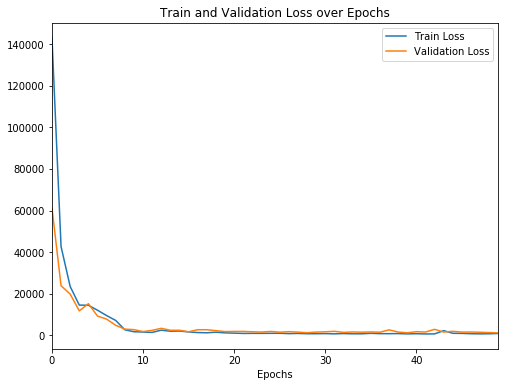

In [19]:
t = [np.mean(tloss[el]) for el in tloss]
v = [np.mean(vloss[el]) for el in vloss]
p = pd.DataFrame({'Train Loss': t, 'Validation Loss': v, 'Epochs': range(50)})

_ = p.plot(x='Epochs', y=['Train Loss', 'Validation Loss'], 
           title='Train and Validation Loss over Epochs')

In [20]:
l = [x for x in feature_cols if x not in ['Industry', 'Sector']]
#m.eval()

X = financial_data[feature_cols]
Y = financial_data['Price']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=123)
    
# Covert to dataloaders
traindl = apply_dl(X_train, y_train, categorical)
valdl = apply_dl(X_test, y_test, categorical)

one, two, three,  four,  five = valdl

y_pred = m(one[0].cuda(), one[1].cuda())